In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm

from typing import Dict

from observational_fear import load
from observational_fear.events import get_block_starts
from neurobox.wide_transforms import resample
from binit.bin import which_bin


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone



In [2]:
DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")

In [3]:
def load_traces_wide_by_mouse(
    data_dir: Path, session: str, sampling_interval: str = "100ms", coreg_only=False
) -> Dict[str, pd.DataFrame]:
    cells = (
        load.load_cells(data_dir)
        .assign(new_id=lambda x: x.new_id.astype(str))
        .groupby("mouse")["new_id"]
        .unique()
        .to_dict()
    )
    if coreg_only:
        coreg_cells =  load.load_block_coreg_cells(data_dir=data_dir)
        is_coreg = lambda x: x in coreg_cells
    else:
        is_coreg = lambda x: True
    traces = (
        load.load_traces(data_dir=data_dir, session=session)
        .set_index("time")
        .pipe(resample, new_interval=sampling_interval)
    )
    return {
        mouse: traces[[c for c in traces.columns if c in ids and is_coreg(c)]]
        for mouse, ids in cells.items()
    }





def load_freeze_status_by_mouse(
    data_dir: Path, session: str, sampling_interval: str = "100ms", role: str = "obs"
) -> pd.DataFrame:
    df_behaviour = load.load_behaviour(data_dir=data_dir, session=session)
    if session == "day2":
        df_behaviour = df_behaviour.loc[lambda x: x.role == role]
    df_freeze = (
        df_behaviour[["time", "was_freezing", "mouse_name"]]
        .set_index("time")
        .pipe(
            resample,
            new_interval=sampling_interval,
            floor=True,
            grouping_cols="mouse_name",
        )
        .round()
        .reset_index()
        .pivot(index="time", columns="mouse_name", values="was_freezing")
    )
    return df_freeze

def load_mouse_names(data_dir):
    return load.load_cells(data_dir)["mouse"].unique()


def rotate_traces(df):
    rotated_vals = np.roll(df.values, np.random.randint(0, len(df) - 1), axis=0)
    return pd.DataFrame(rotated_vals, columns=df.columns, index=df.index)


def all_time_decoding(traces_by_mouse: Dict[str, pd.DataFrame], events_by_mouse: Dict[str, pd.DataFrame],pipe, n_reps=75, cv=None):
    if cv is None:
        cv=KFold(shuffle=False, n_splits=10)
    res = {}
    reps = {}
    mice = list(traces_by_mouse.keys())

    for i, mouse in enumerate(mice):
        if i == 0:
            le = LabelEncoder().fit(events_by_mouse[mouse])
        try:
            traces = traces_by_mouse[mouse]
            freeze = le.transform(events_by_mouse[mouse])
        except KeyError:
            print(f"Data for {mouse} not found")
            continue
        res[mouse] = cross_val_score(clone(pipe), traces.values, freeze, cv=cv, scoring="f1_macro").mean()
        rep_vals = []
        for _ in tqdm(range(n_reps)):
            traces_rot = rotate_traces(traces.copy())
            rep_vals.append( cross_val_score(clone(pipe), traces_rot.values, freeze, cv=cv, scoring="f1_macro").mean())
        reps[mouse] = rep_vals

    df_res = pd.Series(res)
    df_reps = pd.DataFrame(reps)
    return df_res, df_reps

In [4]:
def load_block_status_by_mouse(data_dir: Path, session: str, block_name: str = "US", t_before: float=0, t_after: float =5, sampling_interval: str = "100ms"):
    mice = load_mouse_names(data_dir)
    starts = get_block_starts(session=session, block_name=block_name)
    traces = (
        load.load_traces(data_dir=data_dir, session=session).iloc[:, :3]
        .set_index("time")
        .pipe(resample, new_interval=sampling_interval)
    )
    starts = which_bin(traces.index.values, starts, time_before=t_before, time_after=t_after)

    starts = np.where(np.isnan(starts), "Not Block", "Block")
    return {mouse: pd.Series(index=traces.index, data=starts) for mouse in mice}


def load_traces_wide_by_mouse_two_session(
    data_dir: Path, session1: str, session2: str, sampling_interval: str = "100ms", coreg_only=False
) -> Dict[str, pd.DataFrame]:
    traces_session1 = load_traces_wide_by_mouse(data_dir, session=session1, sampling_interval=sampling_interval, coreg_only=coreg_only)
    traces_session2 = load_traces_wide_by_mouse(data_dir, session=session2, sampling_interval=sampling_interval, coreg_only=coreg_only)

    out = {}
    for mouse in traces_session1.keys():
        t1 = pd.concat({session1: traces_session1[mouse]}, names=['session'])
        t2 = pd.concat({session2: traces_session2[mouse]}, names=['session'])
        # t1 = traces_session1[mouse]
        # t2 = traces_session2[mouse]
        out[mouse] = pd.concat([t1, t2])
    return out



def load_block_status_by_mouse_two_sessions(
        data_dir: Path, session1: str, session2: str, block_name: str = "US", t_before: float=0, t_after: float =5, sampling_interval: str = "100ms"):
    block_session1 = load_block_status_by_mouse(data_dir, session=session1, block_name=block_name, t_before=t_before, t_after=t_after, sampling_interval=sampling_interval)
    block_session2 = load_block_status_by_mouse(data_dir, session=session2, block_name=block_name, t_before=t_before, t_after=t_after, sampling_interval=sampling_interval)

    out = {}
    for mouse in block_session1.keys():
        b1 = block_session1[mouse]
        b1_vals = np.where(b1 == "Block", f"{block_name} {session1}", session1)
        b1 = pd.DataFrame({"block": b1_vals}, index=b1.index)
        b1 = pd.concat({session1: b1}, names=['session'])
        
        b2 = block_session2[mouse]
        b2_vals = np.where(b2 == "Block", f"{block_name} {session2}", session2)
        b2 = pd.DataFrame({"block": b2_vals}, index=b2.index)
        b2 = pd.concat({session2: b2}, names=['session'])
        out[mouse] = pd.concat((b1, b2))
    return out



def plot_results(df_reps, df_res, name):
    df_reps = df_reps.mean().to_frame(name="Shuffles")
    df_obs = df_res.to_frame(name="Observed")

    df = pd.concat([df_reps, df_obs], axis=1)
    df.melt().pipe((sns.pointplot, "data"), x="variable", y="value", hue="variable")
    plt.ylabel("F1 Score")
    plt.title(f"All Time {name} Decoding Performance")
    ax = plt.gca()
    return ax

def save_results(df_reps, df_res, name, outdir):
    df_res.to_csv(outdir / f"All time decoding - {name} - OBSERVED.csv", )
    df_reps.to_csv(outdir / f"All time decoding - {name} - ROTATED.csv", )



def all_time_decoding_2sessions(traces_by_mouse: Dict[str, pd.DataFrame], events_by_mouse: Dict[str, pd.DataFrame], pipe, n_reps=75, cv=None):
    res = {}
    reps = {}
    mice = list(traces_by_mouse.keys())
    if cv is None:
        cv=KFold(shuffle=False, n_splits=10)


    for i, mouse in enumerate(mice):
        if i == 0:
            le = LabelEncoder().fit(events_by_mouse[mouse].values)
        try:
            traces = traces_by_mouse[mouse].values
            freeze = le.transform(events_by_mouse[mouse].values.ravel()).ravel()
        except KeyError:
            print(f"Data for {mouse} not found")
            continue
        
        res[mouse] = cross_val_score(clone(pipe), traces, freeze, cv=cv, scoring="f1_macro").mean()
        rep_vals = []
        sessions = traces_by_mouse[mouse].index.get_level_values("session").unique().values

        for _ in tqdm(range(n_reps)):
            X_s1 = rotate_traces(traces_by_mouse[mouse].loc[(sessions[0], slice(None)), :].copy()).values
            X_s2 = rotate_traces(traces_by_mouse[mouse].loc[(sessions[1], slice(None)), :].copy()).values
            X = np.concatenate((X_s1, X_s2))
            rep_vals.append( cross_val_score(clone(pipe), X, freeze, cv=cv, scoring="f1_macro").mean())
        reps[mouse] = rep_vals

    df_res = pd.Series(res)
    df_reps = pd.DataFrame(reps)
    return df_res, df_reps



In [5]:
N_REPS = 75
OUTDIR = DATA_DIR / "derived" / "All time decoding"
OUTDIR.mkdir(exist_ok=True)

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

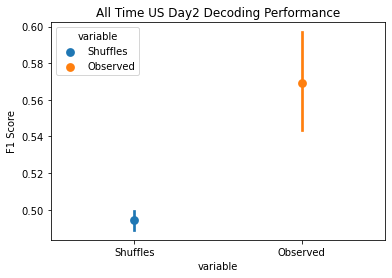

In [13]:
mice = load_mouse_names(DATA_DIR)

name="US Day2"

session="day2"
sampling_interval="200ms"
traces_by_mouse = load_traces_wide_by_mouse(
    data_dir=DATA_DIR,
    session=session,
    sampling_interval=sampling_interval,
    coreg_only=True
)
block_by_mouse = load_block_status_by_mouse(
    data_dir=DATA_DIR,
    session=session,
    sampling_interval=sampling_interval,
    t_after=5
)

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

df_res, df_reps = all_time_decoding(traces_by_mouse, block_by_mouse, n_reps=N_REPS)

plot_results(df_reps, df_res, name=name)
save_results(df_reps, df_res, name, OUTDIR)
plt.savefig(OUTDIR / f"{name}.svg")

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

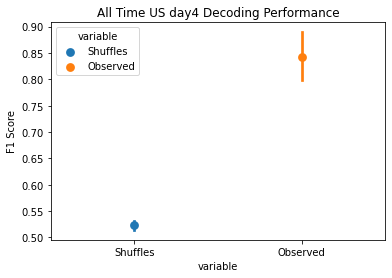

In [14]:
mice = load_mouse_names(DATA_DIR)

session = "day4"
name="US day4"
sampling_interval="200ms"
traces_by_mouse = load_traces_wide_by_mouse(
    data_dir=DATA_DIR,
    session=session,
    sampling_interval=sampling_interval,
    coreg_only=True
)
block_by_mouse = load_block_status_by_mouse(
    data_dir=DATA_DIR,
    session=session,
    sampling_interval=sampling_interval,
    t_after=5
)

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=300))

df_res, df_reps = all_time_decoding(traces_by_mouse, block_by_mouse, n_reps=N_REPS)
ax = plot_results(df_reps, df_res, name=name)
save_results(df_reps, df_res, name, OUTDIR)
plt.savefig(OUTDIR / f"{name}.svg")

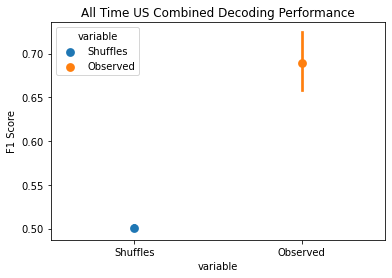

In [56]:
ax = plot_results(df_reps, df_res, name=name)
plt.savefig(OUTDIR / "US Combined.svg")

In [44]:
from sklearn.decomposition import NMF, PCA, KernelPCA, SparsePCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSSVD, PLSCanonical, CCA
from sklearn.svm import SVC

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")
c:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

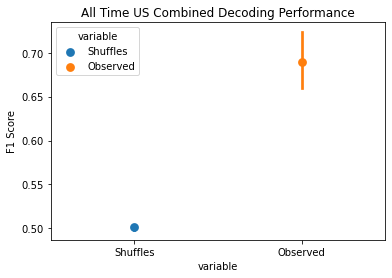

In [54]:
mice = load_mouse_names(DATA_DIR)

name= "US Combined"
sampling_interval="200ms"
traces_by_mouse = load_traces_wide_by_mouse_two_session(
    data_dir=DATA_DIR,
    session1="day2",
    session2="day4",
    sampling_interval=sampling_interval,
    coreg_only=True
)
block_by_mouse = load_block_status_by_mouse_two_sessions(
    data_dir=DATA_DIR,
    session1="day2",
    session2="day4",
    sampling_interval=sampling_interval,
    t_after=5
)


pipe = make_pipeline(RandomForestClassifier(n_jobs=15, n_estimators=150))  # works


df_res, df_reps = all_time_decoding_2sessions(traces_by_mouse, block_by_mouse, pipe=pipe, n_reps=75, cv=StratifiedKFold(shuffle=False, n_splits=10))

plot_results(df_reps, df_res, name=name)
save_results(df_reps, df_res, name, OUTDIR)

In [23]:
pd.concat([block_by_mouse["B17274"], block_by_mouse["B17274"]]).reset_index(drop=True)

0        Not Block
1        Not Block
2        Not Block
3        Not Block
4        Not Block
           ...    
21595    Not Block
21596    Not Block
21597    Not Block
21598    Not Block
21599    Not Block
Length: 21600, dtype: object

In [32]:
block_by_mouse["B17274"]

0        day2
1        day2
2        day2
3        day2
4        day2
         ... 
21595    day4
21596    day4
21597    day4
21598    day4
21599    day4
Length: 21600, dtype: object

In [31]:
traces_by_mouse["B17274"].

new_id,0,1,10,12,29,3,30,31,32,33,...,54,56,58,67,70,72,75,78,81,84
time,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,16.539210,846.283200,90.039760,0.000000,110.168800,0.0,0.000000,0.000000,0.00000,...,36.177095,57.684025,0.000000,103.013835,37.923150,0.000000,79.948920,5.380040,2.368477,1.600871
0.2,0.000000,14.694265,771.985750,85.020730,0.000000,100.101260,0.0,0.000000,2.026469,0.00000,...,63.970790,57.705485,0.000000,103.319850,30.317225,53.077430,77.024040,16.949805,4.886096,2.932581
0.4,0.000000,13.055125,710.134800,80.300235,0.000000,87.018595,0.0,24.912055,3.656125,0.00000,...,54.222305,51.313760,0.000000,97.463765,24.236750,84.121510,79.907660,25.942310,6.954993,15.707060
0.6,0.000000,11.598825,680.640150,87.915870,0.000000,89.652840,0.0,42.073380,3.184273,0.00000,...,45.959395,43.604260,23.561410,94.393665,19.375790,76.298275,70.337330,23.411020,6.426182,27.931685
0.8,0.000000,20.573120,646.856150,93.980415,0.000000,90.416800,0.0,46.269270,13.870960,0.00000,...,38.955655,39.533220,63.379840,84.223150,17.750375,69.202595,72.888090,23.969965,13.609135,36.765660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159.0,4.998988,30.524455,55.614165,31.934995,76.052465,12.381905,0.0,64.188875,0.144007,284.30685,...,81.138560,0.000201,2.573459,98.403465,30.929905,21.807570,20.987585,35.054240,11.381700,32.159050
2159.2,3.844868,27.156895,143.033100,43.932565,68.483510,19.397655,0.0,59.646430,0.123259,306.93950,...,71.611895,0.000175,2.218602,96.653440,40.757915,19.571285,18.198440,31.872610,10.413250,27.916175
2159.4,4.469267,24.160850,143.822300,39.475645,61.667835,14.609720,0.0,53.998170,0.105500,277.15670,...,63.203770,0.000152,1.912678,99.723875,35.516290,17.564320,15.779945,28.979755,9.527200,24.233075


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

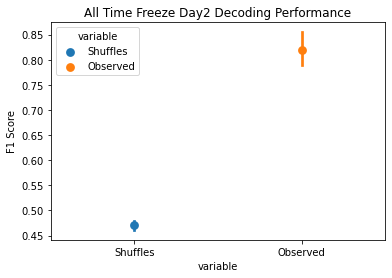

In [15]:
mice = load_mouse_names(DATA_DIR)

session = "day2"
name="Freeze Day2"
sampling_interval="200ms"
traces_by_mouse = load_traces_wide_by_mouse(
    data_dir=DATA_DIR,
    session=session,
    sampling_interval=sampling_interval,
)
freeze_by_mouse = load_freeze_status_by_mouse(
    data_dir=DATA_DIR,
    session=session,
    sampling_interval=sampling_interval,
)

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

df_res, df_reps = all_time_decoding(traces_by_mouse, freeze_by_mouse, n_reps=N_REPS)

plot_results(df_reps, df_res, name=name)
save_results(df_reps, df_res, name, OUTDIR)
plt.savefig(OUTDIR / f"{name}.svg")

In [6]:
mice = load_mouse_names(DATA_DIR)

session = "day4"
name="Freeze Day4"
sampling_interval="200ms"
traces_by_mouse = load_traces_wide_by_mouse(
    data_dir=DATA_DIR,
    session=session,
    sampling_interval=sampling_interval,
)
freeze_by_mouse = load_freeze_status_by_mouse(
    data_dir=DATA_DIR,
    session=session,
    sampling_interval=sampling_interval,
)

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

df_res, df_reps = all_time_decoding(traces_by_mouse, freeze_by_mouse, n_reps=N_REPS)

plot_results(df_reps, df_res, name=name)
save_results(df_reps, df_res, name, OUTDIR)
plt.savefig(OUTDIR / f"{name}.svg")

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


KeyboardInterrupt: 

In [ ]:
load_block_status_by_mouse